**Robinson Foulds (RF) distance** to quantify error between simulated ground-truth and estimated tree 

The assignments of mutational and copy number events to nodes, i.e., their labeling, were obtained by \
the use of `DETOPT`. Here we specifically show how the clonal trees can be unrooted such that the non- \
trivial bipartitions and the RF distance can be computed.

#### **Packages**

In [93]:
import pandas as pd

from graphviz import Digraph
import matplotlib.pyplot as plt
import networkx as nx

from copy import deepcopy
from string import ascii_lowercase

#### **Functions**

In [94]:
def create_graph_from_dict(tree_dict, output_file=''):
    # draw a tree from child parent dictionary
    graph = Digraph('G', format='png')
    
    # node attributes
    graph.attr('node', 
               shape='circle',
               fixedsize='true', 
               width='0.35', 
               height='0.35',
               fontsize='8.75'
               )
    
    # edge attributes
    graph.attr('edge', 
               arrowsize='0.4',
               splines='false'
               )
    
    # convert dictionary, mapping child to parent, to edges
    edges = [(parent, child) for child, parent in tree_dict.items()]

    # add the edges to the graph
    for parent, child in edges:
        graph.edge(parent, child)

    return graph


def create_undirected_graph_from_dict(tree_dict):
    # add nodes/edges to graph, networkx object
    graph = nx.Graph(tree_dict)
    
    # get layout of nodes
    pos = nx.spring_layout(graph)
    
    nx.draw(graph, 
            pos, 
            with_labels=True, 
            node_size=500, 
            node_color='lightgrey', 
            font_family='Arial'
            )
    
    return graph


def create_undirected_graph(graph, pos):    
    # drawing function given graph and layout
    nx.draw(graph, 
            pos, 
            with_labels=True, 
            node_size=500, 
            node_color='lightgrey', 
            font_family='Arial'
            )
    
    return graph


def get_internal_nodes(graph):
    # internal edges have degree > 1
    return [node for node in graph.nodes() if graph.degree(node) > 1]

def get_internal_edges(graph):
    internal_nodes = get_internal_nodes(graph)
    return [(u, v) for (u, v) in graph.edges() \
            if u in internal_nodes and v in internal_nodes]


def extend_internal_nodes_as_leaves(graph, tree_dict):
    internal_nodes = get_internal_nodes(graph)

    for i in internal_nodes:
        if i in tree_dict.keys():
            tree_dict[i] = [tree_dict[i]] + [i+'$']
        else:
            tree_dict[i] = [i+'$']

    return tree_dict


def get_bipartitions(graph):
    internal_edges = get_internal_edges(graph)
    bipartion_set = []

    for edge in internal_edges:
    
        cp_G = deepcopy(graph)
        cp_G.remove_edge(*edge)

        l_bip, r_bip = list(nx.connected_components(cp_G))

        if not len(l_bip) < len(r_bip):

            # stupid, but works
            hold = l_bip
            l_bip = r_bip
            r_bip = hold

        bipartion_set.append(
            f"{''.join(sorted(l_bip))}|{''.join(sorted(r_bip))}"
            )
    
    return bipartion_set

#### **Unrooted tree representation of clonal trees**

**Clonal tree**

In [95]:
TREE_FILE = './simNo_1-s_11-m_100-h_40-cna_0.1.tree.tsv' # example of simulated tree

In [96]:
tree = pd.read_csv(TREE_FILE, sep='\t')
tree_dict = tree.set_index('NODE_ID')['PARENT_ID'].to_dict()

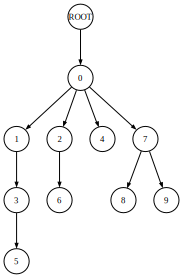

In [97]:
del tree_dict['ROOT']
graph = create_graph_from_dict(tree_dict, '')

graph

Delete the root from the clonal tree since no mutations are assigned to the root node; the root \
represents the subpopulation of normal cells, free of genomic aberrations. Below, we give the \
same tree but with the ROOT removed.

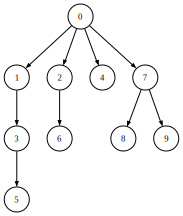

In [98]:
del tree_dict['0']
graph = create_graph_from_dict(tree_dict, '')

graph

**Unrooted tree**

The clonal tree can be represented as an acyclic, undirected graph, i.e., an unrooted tree \
by changing the directed edges into undirected edges. Consider this unrooted tree, as a \
spanning tree on the set of *observed* cancer subclones.

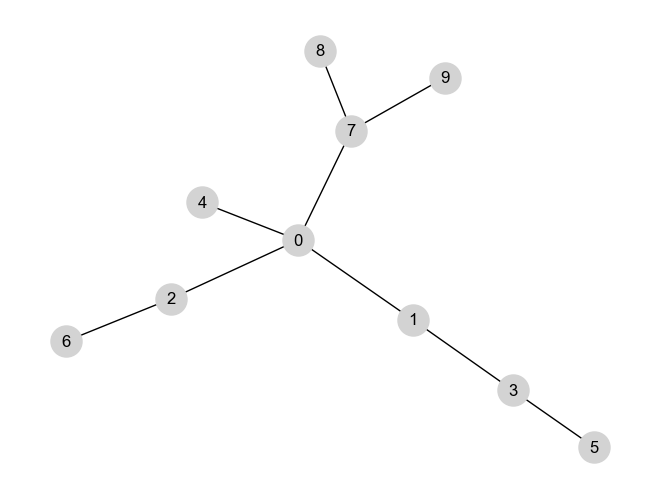

In [99]:
tree_dict_not_ext = deepcopy(tree_dict)
graph = create_undirected_graph_from_dict(tree_dict)

It can easily be seen that we can extend the internal nodes, and respectively their labels, \
 such that each subclone becomes a leaf node in the unrooted tree.

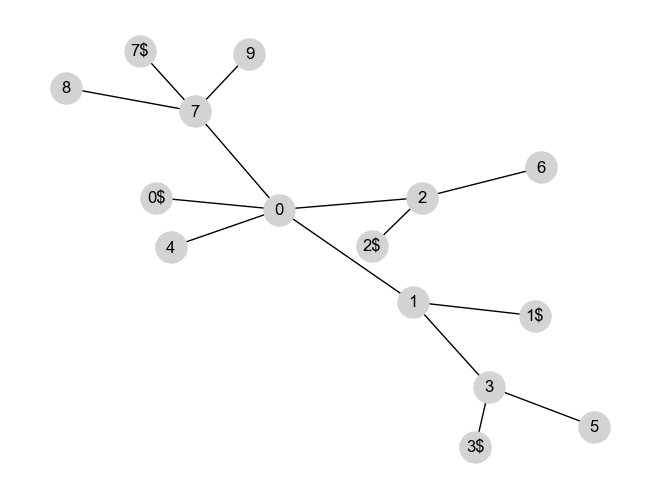

In [70]:
tree_dict_ext = extend_internal_nodes_as_leaves(graph, tree_dict)
ext_graph = create_undirected_graph_from_dict(tree_dict_ext)

Then, we can arbitrarily relabel the internal nodes. Then, to find the non-trivial bipartitions, \
we would just cut each internal edge, e.g., (*b*, *e*), and for each cut, identify the leaf sets of \
the two resultant trees.

In [71]:
internal_nodes = get_internal_nodes(graph)
leaf_labels = map(lambda x: f'{x}$', internal_nodes)

rename_internal_nodes = dict(zip(internal_nodes, ascii_lowercase))
rename_leaf_nodes = dict(zip(leaf_labels, internal_nodes))
rename_internal_nodes.update(rename_leaf_nodes)

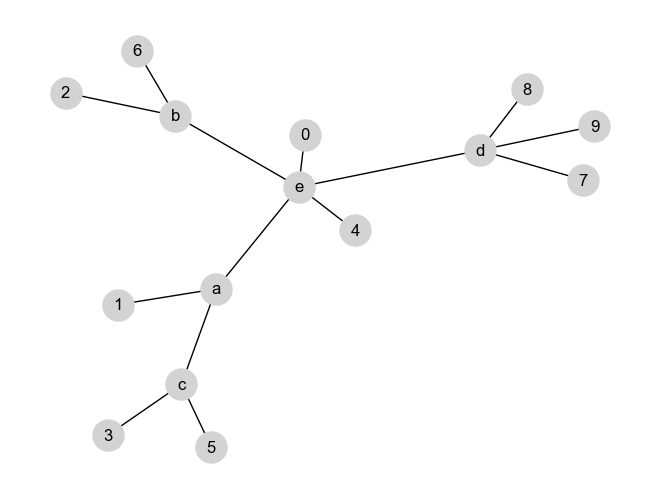

In [72]:
node_mapping = rename_internal_nodes
G_renamed = nx.relabel_nodes(ext_graph, node_mapping)

pos = nx.spring_layout(G_renamed)
full = create_undirected_graph(G_renamed, pos)

#### **Bipartions of (now unrooted) clonal trees**

But it is actually not necessary to extend the internal nodes to leaves to find the tree \
bipartitions. We show an example below; cutting the internal edge (*0*, *1*) in the tree \
below is the same as cutting the internal edge (*a*, *e*) in the tree above.

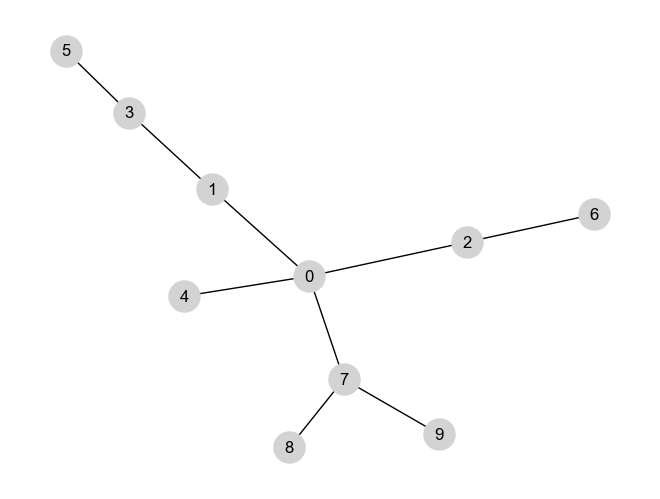

In [73]:
graph = create_undirected_graph_from_dict(tree_dict_not_ext)
cp_G = deepcopy(nx.Graph(tree_dict_not_ext)) # copy of graph

In [74]:
internal_edges = get_internal_edges(graph)

print(internal_edges[0])
cp_G.remove_edge(*internal_edges[0])

('1', '0')


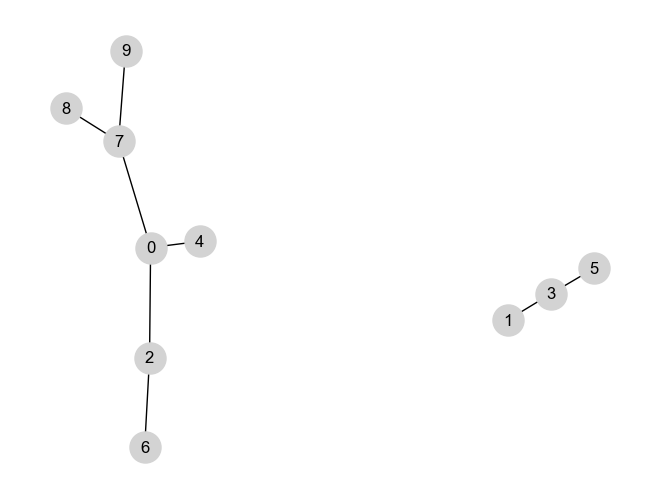

In [75]:
pos = nx.spring_layout(cp_G) 
prev = create_undirected_graph(cp_G, pos)

Below is the set of non-trivial bipartitions of the graph.

In [76]:
bipartion_set = get_bipartitions(graph)
bipartion_set

['135|0246789', '35|01246789', '26|01345789', '789|0123456']

#### **`Robinson-Foulds` Distance Function**

In [180]:
def robinson_foulds_distance(bip1, bip2):
    # given two bipartition sets from two trees, return the RF distance

    _bip1,_bip2 = set(bip1), set(bip2)
    uniq_bipartitions = _bip1.symmetric_difference(_bip2)

    return len(uniq_bipartitions)

#### **Example of using RF distance** (as mentioned in main text)

In `DETOPT` (and in its extension), we assign to each node (subclone) mutations to indicate \
when in the phylogeny the mutation occured for the first time. This means that each node has \
a unique assignment of a mutation (from the set of all mutations). In our simulations, we have \
ground-truth assignments of where these mutations should be placed (column named `SNV_IDS` \
in the table below for its corresponding node as given by column named `NODE_ID`).

**Importantly**, we are using the RF distance as a way to evaluate how badly the mutation \
was placed. The two other measures only say whether the placement preserves ancestor- \
descendant relationship of mutation pairs. 

By using the RF distance, we have some more granularity. For instance, suppose that a mutation \
is incorrectly placed in a different lineage/branch (to the node it is assigned to in the ground- \
truth tree). The RF distance can be used as an approximation to *how far away the incorrect placement* \
*is to the ground-truth placement*. If the mutation is placed towards the leaves in a different branch, \
the RF distance is higher than if it was placed closer to the root (and closer to the correct placement).

In [181]:
tree

,NODE_ID,PARENT_ID,SNV_IDS,SNV_ALLELES,CNA_IDS,CNA_CHANGES,SAMPLE_IDS,SAMPLE_NODE_FREQUENCIES
0,ROOT,NONE,NaN,NaN,NaN,NaN,"MASTER_SAMPLE,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S1...","0.1108,0.1348,0.1639,0.1279,0.1308,0.0694,0.13..."
1,0,ROOT,"mut0,mut1,mut2,mut3,mut4,mut5,mut6","M,P,M,P,P,P,P",cna_mut53,"(1,0)","MASTER_SAMPLE,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S1...","0.1040,0.0433,0.1011,0.0234,0.0162,0.1490,0.14..."
2,1,0,"mut7,mut8,mut9,mut10,mut11,mut12,mut13,mut14","M,P,M,M,P,P,M,P",NaN,NaN,"MASTER_SAMPLE,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S1...","0.0402,0.1069,0.0913,0.1353,0.0782,0.1241,0.13..."
3,2,0,"mut15,mut16,mut17,mut18,mut19,mut20,mut21,mut2...","M,P,P,P,M,M,M,P,M,M,M,P,P","cna_mut49,cna_mut93","(0,1),(0,-1)","MASTER_SAMPLE,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S1...","0.1091,0.0579,0.0356,0.1328,0.0390,0.0702,0.12..."
4,3,1,"mut28,mut29,mut30,mut31,mut32,mut33,mut34,mut3...","M,M,P,P,M,P,M,P,M,P",cna_mut48,"(0,1)","MASTER_SAMPLE,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S1...","0.0230,0.1436,0.0946,0.0690,0.1601,0.0837,0.01..."
5,4,0,"mut38,mut39,mut40,mut41,mut42,mut43,mut44,mut45","M,P,M,P,P,M,P,M","cna_mut71,cna_mut50","(1,0),(0,-1)","MASTER_SAMPLE,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S1...","0.0871,0.0989,0.1794,0.1320,0.1038,0.0498,0.12..."
6,5,3,"mut46,mut47,mut48,mut49,mut50,mut51,mut52,mut5...","P,P,M,M,P,P,M,P,P,M,P",cna_mut63,"(0,1)","MASTER_SAMPLE,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S1...","0.0473,0.1210,0.1064,0.1099,0.0485,0.1455,0.02..."
7,6,2,"mut57,mut58,mut59,mut60,mut61,mut62,mut63,mut6...","M,P,P,P,M,M,M,M,P,M","cna_mut97,cna_mut22","(0,-1),(0,-1)","MASTER_SAMPLE,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S1...","0.1127,0.0936,0.0207,0.0461,0.1691,0.0668,0.10..."
8,7,0,"mut67,mut68,mut69,mut70,mut71,mut72,mut73,mut7...","M,P,P,P,M,M,M,P,M,P,P,M,M",NaN,NaN,"MASTER_SAMPLE,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S1...","0.1324,0.0482,0.0510,0.1407,0.0725,0.1191,0.03..."
9,8,7,"mut80,mut81,mut82,mut83,mut84,mut85,mut86,mut8...","M,M,P,M,M,M,M,M,M,P",NaN,NaN,"MASTER_SAMPLE,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,S1...","0.1113,0.0619,0.1170,0.0243,0.1405,0.0145,0.06..."


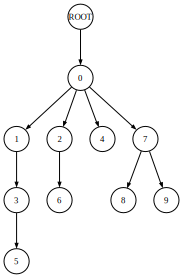

In [182]:
tree_dict = tree.set_index('NODE_ID')['PARENT_ID'].to_dict()
del tree_dict['ROOT']
graph = create_graph_from_dict(tree_dict, '')

graph

As an example to how the RF distance can be used, consider that our tool, `DETOPT`, \
**assigns a mutation erroneously** to node (subclone) 9, instead of node (subclone) 3.


We swap the labels of node 3 and node 9, and then delete node 9 to reflect that \
the mutation was incorrectly placed.

In [183]:
incorrect_assign_tree_dict = deepcopy(tree_dict)

In [184]:
incorrect_assign_tree_dict['3'] = '7'
incorrect_assign_tree_dict['5'] = '1'

del incorrect_assign_tree_dict['9']

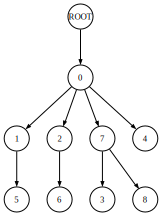

In [185]:
graph_ex = create_graph_from_dict(incorrect_assign_tree_dict, '')
graph_ex

We augment the ground-truth tree such that it is the induced subtree on the \
set of leaves of the tree above, i.e., delete node 9 from the original tree.

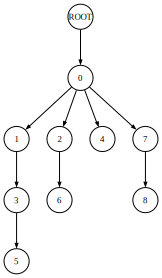

In [186]:
del tree_dict['9'] 
graph = create_graph_from_dict(tree_dict, '')

graph

We generate the unrooted representation of these clonal trees and \
calculate the RF distance.

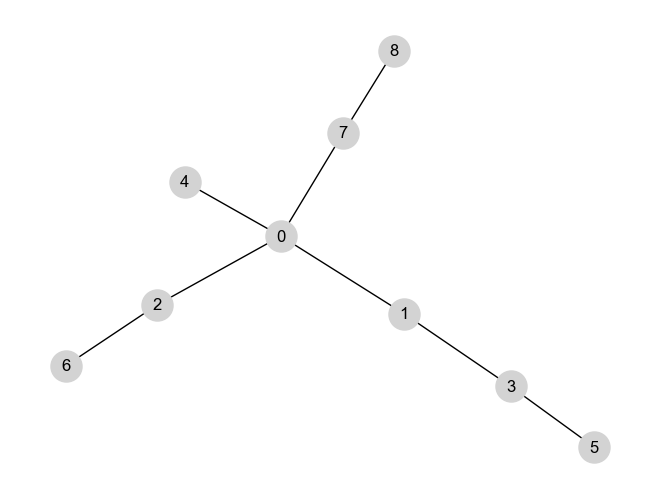

In [187]:
tree_dict_not_ext = deepcopy(tree_dict)
del tree_dict_not_ext['0']
graph_unrooted = create_undirected_graph_from_dict(tree_dict_not_ext)

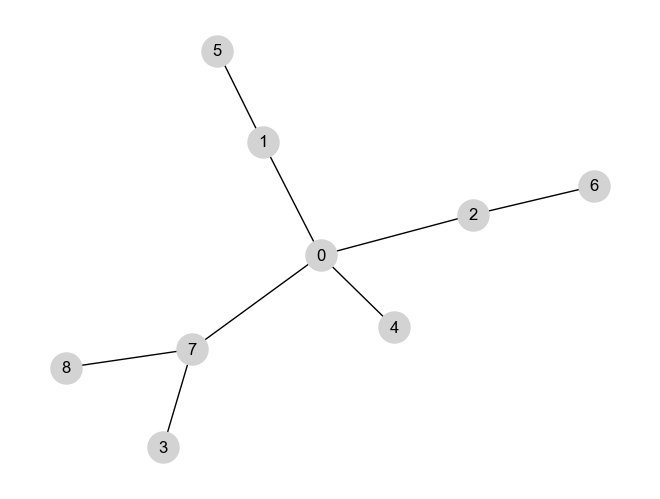

In [188]:
del incorrect_assign_tree_dict['0']
graph_ex_unrooted = create_graph_from_dict(incorrect_assign_tree_dict, '')
graph_ex_unrooted = create_undirected_graph_from_dict(incorrect_assign_tree_dict)

In [189]:
get_bipartitions(graph_unrooted)

['135|024678', '35|0124678', '26|0134578', '78|0123456']

In [190]:
get_bipartitions(graph_ex_unrooted)

['15|0234678', '26|0134578', '378|012456']

In [192]:
rf_dist = robinson_foulds_distance(get_bipartitions(graph_unrooted), get_bipartitions(graph_ex_unrooted))
print(f'The RF distance between these two trees is: {rf_dist}')

The RF distance between these two trees is: 5


We take the average RF distance for all incorrectly assigned mutations \
as an approximation of the tree error.